# PREDICTOR GASTO TURÍSTICO EN OTROS 
## GMI_join_cc_cs_filtroPI_FCanarias

- SOLO PARA EL TOTAL  DE LAS ISLAS CANARIAS (NO TIENE FTV,GC,TNF...)
- TIENE LAS CARAECTEÍSTICAS DE CLIENTE
- TIENE LAS CARACTERÍSTICAS DE SOPORTE

# 03

# Proposito:

En este notebook nos dedicaremos a la creación del **predictor** para **gasto en otros**

In [1]:
%load_ext watermark
%watermark

Last updated: 2023-02-22T17:25:03.052490+00:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [2]:
# Lectura y escritura de datos
# ==============================================================================
import os
import re

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

C:\Users\angel\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


**WARNING**
C:\Users\angel\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED

Solucion: !pip install --upgrade panda

# PREPARACION PREVIA

Primero necesitamos copiar todos nuestros archivos en una carpeta donde podramos manipularlos para así conservar los archivos originales

In [3]:
from distutils.dir_util import copy_tree

# Método que limpia la carpeta de datos volatiles ya que es 
# una carpeta activa en todos los programas que hemos generado.
def limpiaCarpetaVolatil(rutaCopia):
    print("Limpiando Carpeta Volatil...")
    for f in os.listdir(rutaCopia):
        os.remove(os.path.join(rutaCopia, f))
        
#Metodo que copia recursivamente
def copia(dir_origen,dir_destino):
    print("Copiando...")
    copy_tree(dir_origen, dir_destino)
    print("Copiado")
    print(os.listdir(dir_destino))
  


In [4]:
rutaBase= "../PredictorGastoTuristico/DatosPredictor/02/"
rutaCopia= "../PredictorGastoTuristico/DatosVolatiles/"

limpiaCarpetaVolatil(rutaCopia)
copia(rutaBase,rutaCopia)

Limpiando Carpeta Volatil...
Copiando...
Copiado
['GMI_join_cc_cs_filtroPI_FCanarias.csv']


## Primero cargamos los archivos para tratarlos y finalmente unirlos:

In [5]:
gasto_medio = pd.read_csv(rutaCopia+'GMI_join_cc_cs_filtroPI_FCanarias.csv',keep_default_na=False, na_values=[""])

In [6]:
gasto_medio.head()

,isla,fecha,Ingresos totales,RevPAR,ADR,pais,Total Turistas,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,...,Total Turistas por motivo: Trabajo o negocios,Total Turistas: No contrataron un paquete turístico,Total Turistas: Sí contrataron un paquete turístico,Total Turistas: Total,Establecimientos abiertos,Hab-aprt disponibles,Plazas ofertadas,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas
0,CANARIAS,2010Q1,647140262.7,40.72,58.483333,Alemania,620920.0,1147.19,472.84,341.47,...,4134.0,154831.0,466089.0,620920.0,5524.0,528460.0,1304800.0,11.340000,69.603333,58.31
1,CANARIAS,2010Q1,647140262.7,40.72,58.483333,España,335230.0,666.96,238.65,166.80,...,53619.0,201097.0,134132.0,335230.0,5524.0,528460.0,1304800.0,4.683333,69.603333,58.31
2,CANARIAS,2010Q1,647140262.7,40.72,58.483333,Holanda,94439.0,1107.77,455.40,337.60,...,961.0,21215.0,73224.0,94439.0,5524.0,528460.0,1304800.0,10.133333,69.603333,58.31
3,CANARIAS,2010Q1,647140262.7,40.72,58.483333,Otros países,439882.0,1023.57,417.21,291.47,...,11445.0,185037.0,254843.0,439881.0,5524.0,528460.0,1304800.0,9.021667,69.603333,58.31
4,CANARIAS,2010Q1,647140262.7,40.72,58.483333,Países Nórdicos,537221.0,1193.58,448.43,294.31,...,3339.0,81875.0,455346.0,537220.0,5524.0,528460.0,1304800.0,8.546667,69.603333,58.31


Convertimos la columan fecha en PeriodIndex, usando pd.PeriodIndex(). Una vez en dicho formato, se establece como índice.

In [7]:
###gasto_medio['fecha'] = pd.to_datetime(gasto_medio['fecha'], format='%YQ%m')
###gasto_medio = gasto_medio.set_index('fecha')
###gasto_medio = gasto_medio.asfreq('MS')
###gasto_medio = gasto_medio.sort_index() #Ordenamos
###gasto_medio.head()

In [8]:
gasto_medio['fecha'] = pd.PeriodIndex(gasto_medio.fecha, freq="Q", dtype='period[Q-DEC]')
gasto_medio = gasto_medio.set_index('fecha')
gasto_medio = gasto_medio.sort_index() #Ordenamos
gasto_medio.head()

,isla,Ingresos totales,RevPAR,ADR,pais,Total Turistas,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,...,Total Turistas por motivo: Trabajo o negocios,Total Turistas: No contrataron un paquete turístico,Total Turistas: Sí contrataron un paquete turístico,Total Turistas: Total,Establecimientos abiertos,Hab-aprt disponibles,Plazas ofertadas,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,CANARIAS,647140262.7,40.72,58.483333,Alemania,620920.0,1147.19,472.84,341.47,332.88,...,4134.0,154831.0,466089.0,620920.0,5524.0,528460.0,1304800.0,11.340000,69.603333,58.31
2010Q1,CANARIAS,647140262.7,40.72,58.483333,España,335230.0,666.96,238.65,166.80,261.51,...,53619.0,201097.0,134132.0,335230.0,5524.0,528460.0,1304800.0,4.683333,69.603333,58.31
2010Q1,CANARIAS,647140262.7,40.72,58.483333,Holanda,94439.0,1107.77,455.40,337.60,314.77,...,961.0,21215.0,73224.0,94439.0,5524.0,528460.0,1304800.0,10.133333,69.603333,58.31
2010Q1,CANARIAS,647140262.7,40.72,58.483333,Otros países,439882.0,1023.57,417.21,291.47,314.90,...,11445.0,185037.0,254843.0,439881.0,5524.0,528460.0,1304800.0,9.021667,69.603333,58.31
2010Q1,CANARIAS,647140262.7,40.72,58.483333,Países Nórdicos,537221.0,1193.58,448.43,294.31,450.84,...,3339.0,81875.0,455346.0,537220.0,5524.0,528460.0,1304800.0,8.546667,69.603333,58.31


In [9]:
gasto_medio.shape

(280, 36)

In [10]:
df = pd.get_dummies(gasto_medio, columns=['pais'])
df.head()

,isla,Ingresos totales,RevPAR,ADR,Total Turistas,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,Turistas Hombres De 15 a 24,...,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas,pais_Alemania,pais_España,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,pais_TOTAL
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,CANARIAS,647140262.7,40.72,58.483333,620920.0,1147.19,472.84,341.47,332.88,16718.0,...,11.340000,69.603333,58.31,1,0,0,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,335230.0,666.96,238.65,166.80,261.51,10179.0,...,4.683333,69.603333,58.31,0,1,0,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,94439.0,1107.77,455.40,337.60,314.77,2861.0,...,10.133333,69.603333,58.31,0,0,1,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,439882.0,1023.57,417.21,291.47,314.90,11874.0,...,9.021667,69.603333,58.31,0,0,0,1,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,537221.0,1193.58,448.43,294.31,450.84,14060.0,...,8.546667,69.603333,58.31,0,0,0,0,1,0,0


In [11]:
#df.dtypes

In [12]:
gasto_medio = df
gasto_medio.head()

,isla,Ingresos totales,RevPAR,ADR,Total Turistas,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,Turistas Hombres De 15 a 24,...,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas,pais_Alemania,pais_España,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,pais_TOTAL
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,CANARIAS,647140262.7,40.72,58.483333,620920.0,1147.19,472.84,341.47,332.88,16718.0,...,11.340000,69.603333,58.31,1,0,0,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,335230.0,666.96,238.65,166.80,261.51,10179.0,...,4.683333,69.603333,58.31,0,1,0,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,94439.0,1107.77,455.40,337.60,314.77,2861.0,...,10.133333,69.603333,58.31,0,0,1,0,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,439882.0,1023.57,417.21,291.47,314.90,11874.0,...,9.021667,69.603333,58.31,0,0,0,1,0,0,0
2010Q1,CANARIAS,647140262.7,40.72,58.483333,537221.0,1193.58,448.43,294.31,450.84,14060.0,...,8.546667,69.603333,58.31,0,0,0,0,1,0,0


**Variables Dummy**

Es necesario recordar que pada evitar la multicolineaidad debemos quitar una columna de las variables dummy que creamos, ya que si las ponemos todas creamos una dependencia circular.

### NOTA:
**Para evitar el sigueiente error:**

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Debemos eliminar los valores nulos de las columnas del df**

In [13]:
gasto_medio.isnull().sum()

isla                                                     0
Ingresos totales                                         0
RevPAR                                                   0
ADR                                                      0
Total Turistas                                           0
total gasto por turista                                  0
gasto por turista alojamiento                            0
gasto por turista transporte nacional / internacional    0
gasto por turista  otros                                 0
Turistas Hombres De 15 a 24                              0
Turistas Mujeres De 15 a 24                              0
Turistas Hombres De 25 a 44                              0
Turistas Mujeres De 25 a 44                              0
Turistas Hombres De 45 a 64                              0
Turistas Mujeres De 45 a 64                              0
Turistas Hombres Mayor de 64                             0
Turistas Mujeres Mayor de 64                            

In [14]:
gasto_medio = gasto_medio.dropna()

In [15]:
gasto_medio.columns

Index(['isla', 'Ingresos totales', 'RevPAR', 'ADR', 'Total Turistas',
       'total gasto por turista', 'gasto por turista alojamiento',
       'gasto por turista transporte nacional / internacional',
       'gasto por turista  otros', 'Turistas Hombres De 15 a 24',
       'Turistas Mujeres De 15 a 24', 'Turistas Hombres De 25 a 44',
       'Turistas Mujeres De 25 a 44', 'Turistas Hombres De 45 a 64',
       'Turistas Mujeres De 45 a 64', 'Turistas Hombres Mayor de 64',
       'Turistas Mujeres Mayor de 64', 'Turistas Hombres Menor de 15',
       'Turistas Mujeres Menor de 15', 'Turistas Hombres TOTAL EDADES',
       'Turistas Mujeres TOTAL EDADES',
       'Total Turistas por motivo: Ocio o vacaciones',
       'Total Turistas por motivo: Otros motivos',
       'Total Turistas por motivo: Personal',
       'Total Turistas por motivo: TOTAL MOTIVOS',
       'Total Turistas por motivo: Trabajo o negocios',
       'Total Turistas: No contrataron un paquete turístico',
       'Total Turista

- **quite total gasto por turista** ya que me al final es la suma de todos los gastos asique facilira la predicción... al ser una variable dependiente de otras, aporta demasasida infromación
- **quite gasto por turista  otros** porque es la variable a predecir...
- **quite isla** porque CANARIAS es la unica que hay asi que esa columna puede quitarse
- **quite pais_Total** para evitar la multicolinealidad de las **variables dummy**


In [16]:
nombres_variables_independientes = [
       'Ingresos totales', 'RevPAR', 'ADR', 'Total Turistas',
       
       'gasto por turista alojamiento',
       'gasto por turista transporte nacional / internacional', 
    
        'Turistas Hombres De 15 a 24',
       'Turistas Mujeres De 15 a 24', 'Turistas Hombres De 25 a 44',
       'Turistas Mujeres De 25 a 44', 'Turistas Hombres De 45 a 64',
       'Turistas Mujeres De 45 a 64', 'Turistas Hombres Mayor de 64',
       'Turistas Mujeres Mayor de 64', 'Turistas Hombres Menor de 15',
       'Turistas Mujeres Menor de 15', 'Turistas Hombres TOTAL EDADES',
       'Turistas Mujeres TOTAL EDADES',
       'Total Turistas por motivo: Ocio o vacaciones',
       'Total Turistas por motivo: Otros motivos',
       'Total Turistas por motivo: Personal',
       'Total Turistas por motivo: TOTAL MOTIVOS',
       'Total Turistas por motivo: Trabajo o negocios',
       'Total Turistas: No contrataron un paquete turístico',
       'Total Turistas: Sí contrataron un paquete turístico',
       'Total Turistas: Total', 'Establecimientos abiertos',
       'Hab-aprt disponibles', 'Plazas ofertadas', 'Estancia media',
       'Tasa ocupación por Hab-aprt', 'Tasa ocupación por plazas',
       'pais_Alemania', 'pais_España', 'pais_Holanda', 'pais_Otros países',
       'pais_Países Nórdicos', 'pais_Reino Unido' ]

In [17]:
gasto_medio[nombres_variables_independientes]

,Ingresos totales,RevPAR,ADR,Total Turistas,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,Turistas Hombres De 15 a 24,Turistas Mujeres De 15 a 24,Turistas Hombres De 25 a 44,Turistas Mujeres De 25 a 44,...,Plazas ofertadas,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas,pais_Alemania,pais_España,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,6.471403e+08,40.720000,58.483333,620920.0,472.84,341.47,16718.0,15374.0,93932.0,100462.0,...,1304800.0,11.340000,69.603333,58.310000,1,0,0,0,0,0
2010Q1,6.471403e+08,40.720000,58.483333,335230.0,238.65,166.80,10179.0,8403.0,55682.0,48843.0,...,1304800.0,4.683333,69.603333,58.310000,0,1,0,0,0,0
2010Q1,6.471403e+08,40.720000,58.483333,94439.0,455.40,337.60,2861.0,2899.0,13466.0,15240.0,...,1304800.0,10.133333,69.603333,58.310000,0,0,1,0,0,0
2010Q1,6.471403e+08,40.720000,58.483333,439882.0,417.21,291.47,11874.0,12365.0,68137.0,69403.0,...,1304800.0,9.021667,69.603333,58.310000,0,0,0,1,0,0
2010Q1,6.471403e+08,40.720000,58.483333,537221.0,448.43,294.31,14060.0,15458.0,81840.0,85275.0,...,1304800.0,8.546667,69.603333,58.310000,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019Q4,1.085904e+09,68.833333,88.476667,153223.0,476.95,353.55,2223.0,3693.0,24060.0,24084.0,...,1255373.0,8.236667,77.786667,66.046667,0,0,1,0,0,0
2019Q4,1.085904e+09,68.833333,88.476667,829163.0,452.73,331.38,15539.0,20712.0,158701.0,146205.0,...,1255373.0,7.701667,77.786667,66.046667,0,0,0,1,0,0
2019Q4,1.085904e+09,68.833333,88.476667,575908.0,490.14,557.86,14174.0,17841.0,63037.0,71739.0,...,1255373.0,7.698333,77.786667,66.046667,0,0,0,0,1,0


In [18]:
nombre_variable_objetiva = ['gasto por turista  otros']

# AQUÍ DIVIDIMOS EL DATASET EN TRAIN Y TEST

In [19]:
aux1 = gasto_medio[nombres_variables_independientes]
aux2 = gasto_medio[nombre_variable_objetiva]

In [20]:
aux2.head()

,gasto por turista otros
fecha,
2010Q1,332.88
2010Q1,261.51
2010Q1,314.77
2010Q1,314.90
2010Q1,450.84


Fechas train : 2010Q1 --- 2017Q4  (n=224)
Fechas test  : 2018Q1 --- 2019Q4  (n=56)
Fechas train variable objetivo: 2010Q1 --- 2017Q4  (n=224)
Fechas test variable objetivo: 2018Q1 --- 2019Q4  (n=56)


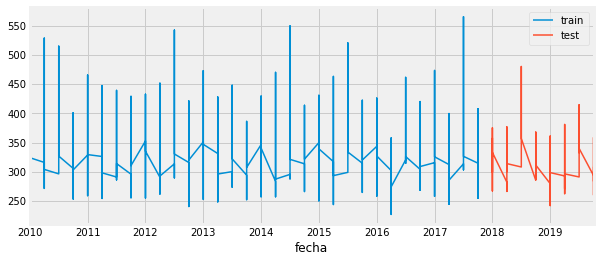

In [21]:
# Separación datos train-test
# ==============================================================================

# el data set tiene 1390 filas y 24 columnas
# hay 10 fechas distintas asique steps = 280/10 = 28 que es la cantidad de steps para visualizar un año

# esto pasa porque hay 10 fechas diferentes, pero tambien hay 7 paises, por lo que el numero
# de ocurrencias de una misma fecha es multiple.

# por tanto para coger e test 2018 y 2019, steps debe valer 28*2 = 56
# para 2017 - 2019 28*3 = 84

steps = 28*2
X_train = aux1[:-steps]
X_test  = aux1[-steps:]

Y_train = aux2[:-steps]
Y_test  = aux2[-steps:]

print(f"Fechas train : {X_train.index.min()} --- {X_train.index.max()}  (n={len(X_train)})")
print(f"Fechas test  : {X_test.index.min()} --- {X_test.index.max()}  (n={len(X_test)})")


print(f"Fechas train variable objetivo: {Y_train.index.min()} --- {Y_train.index.max()}  (n={len(Y_train)})")
print(f"Fechas test variable objetivo: {Y_test.index.min()} --- {Y_test.index.max()}  (n={len(Y_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
Y_train['gasto por turista  otros'].plot(ax=ax, label='train')
Y_test['gasto por turista  otros'].plot(ax=ax, label='test')
ax.legend();

# PREDICTOR

Nota: Predecir 2017-2019 da mejores resultados qque 2018-2019

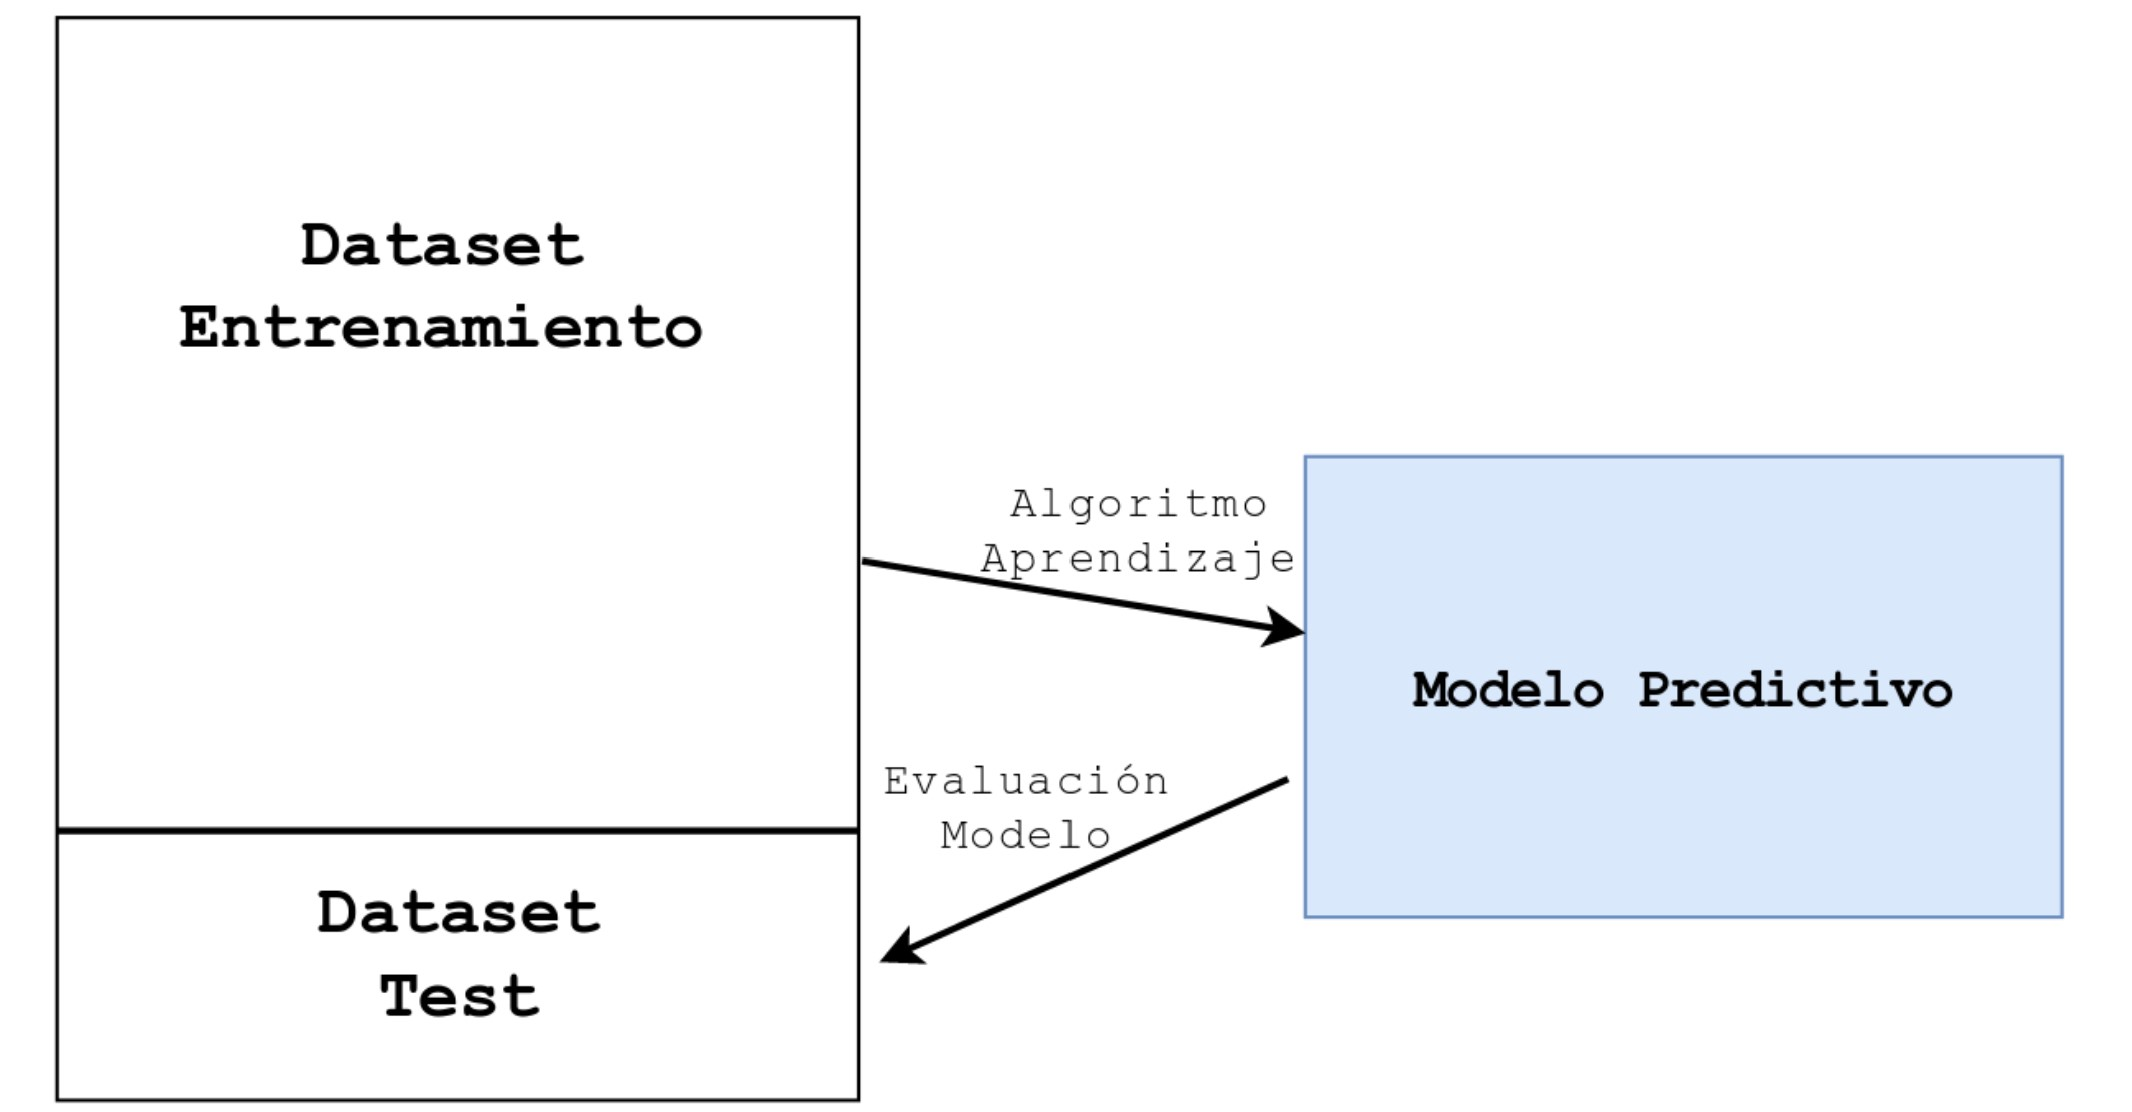

In [22]:
from IPython.display import Image

Image("../PredictorGastoTuristico/OtrosRecursos/Imagenes/img01.jpg")

## MEDIDAS DE EVALUACIÓN DEL MODELO

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

Aqui definimso las **Medidas de evaluación:**

    - RMSE (Root Mean Squared Error) Raiz cuadrada del error absoluto medio al cuadrado
    - adjusted_r2 Coeficiente de Determinacion ajustado
    - MAE (Mean Absolute error)

In [24]:
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))

def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": rmse(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k),
           }


# AQUÍ AJUSTAMOS EL MODELO DE REGRESION LINEAL MÚLTIPLE

Ademas, evaluamos el modelo de entrenamiento y test

In [25]:
RESULTADOS_OLS = {}

modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=Y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)


RESULTADOS_OLS["OLS_train"] = evaluar_modelo(
    Y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS_OLS["OLS_test"] = evaluar_modelo(
    Y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS_OLS)

,OLS_train,OLS_test
rmse,19.332206,47.779477
mae,13.560794,38.819622
adjusted_r2,0.904312,-0.126527


In [26]:
gasto_medio['gasto por turista  otros'].describe()

count    280.000000
mean     323.802679
std       59.701036
min      227.020000
25%      285.587500
50%      313.605000
75%      340.707500
max      565.130000
Name: gasto por turista  otros, dtype: float64

In [27]:
# Gráfico
# ==============================================================================
#fig, ax = plt.subplots(figsize=(9, 4))
#Y_train['gasto por turista  otros'].plot(ax=ax, label='train')
#Y_test['gasto por turista  otros'].plot(ax=ax, label='test')
#modelo_ols_test_preds.plot(ax=ax, label='predicciones')
#ax.legend();

In [28]:
#print(modelo_ols_test_preds)

In [29]:
#plt.plot(modelo_ols_test_preds)
#plt.show()

## VISUALIZAMOS LA MATRIZ DE CORRELACION, AUNQUE SABEMOS QUE NO ES DETERMINANTE

In [30]:
df = gasto_medio

In [31]:
#crear matriz de correlación
df.corr()
#crear la misma matriz de correlación con coeficientes redondeados a 3 decimales 


<ipython-input-31-c04b8bf462c6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Ingresos totales,RevPAR,ADR,Total Turistas,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,Turistas Hombres De 15 a 24,Turistas Mujeres De 15 a 24,...,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas,pais_Alemania,pais_España,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,pais_TOTAL
Ingresos totales,1.000000e+00,9.982779e-01,9.497784e-01,0.135825,0.284220,0.367204,0.294482,0.009832,-0.004732,0.060721,...,-0.053112,9.028726e-01,8.691729e-01,1.401737e-16,5.823834e-17,-2.450027e-17,-9.036983e-17,-8.233696e-17,5.141039e-17,-2.570520e-17
RevPAR,9.982779e-01,1.000000e+00,9.579653e-01,0.135748,0.283396,0.369101,0.293769,0.005456,-0.006936,0.061258,...,-0.057437,8.944499e-01,8.663263e-01,8.983528e-17,1.063356e-17,-2.310050e-17,-7.076820e-17,-7.076820e-17,5.536787e-17,2.933397e-18
ADR,9.497784e-01,9.579653e-01,1.000000e+00,0.130861,0.288591,0.378343,0.318137,-0.018730,-0.014070,0.061279,...,-0.101068,7.346821e-01,7.656912e-01,1.329709e-16,3.880136e-17,-4.098121e-17,-9.111779e-17,-5.624017e-17,6.234375e-17,6.975525e-18
Total Turistas,1.358252e-01,1.357481e-01,1.308609e-01,1.000000,0.043794,0.139570,0.029756,-0.098863,0.866961,0.878299,...,-0.045542,1.214949e-01,1.216478e-01,-1.079242e-01,-2.144217e-01,-3.239579e-01,-1.039495e-01,-2.221161e-01,3.474458e-02,9.376249e-01
total gasto por turista,2.842201e-01,2.833957e-01,2.885914e-01,0.043794,1.000000,0.928645,0.912150,0.684664,0.061043,0.077778,...,0.689361,2.316541e-01,3.542996e-01,3.009051e-01,-6.826316e-01,5.770231e-02,1.043880e-01,4.219615e-01,-1.979369e-01,-4.388588e-03
gasto por turista alojamiento,3.672043e-01,3.691010e-01,3.783433e-01,0.139570,0.928645,1.000000,0.864509,0.421885,0.129546,0.156328,...,0.696180,2.920969e-01,3.959043e-01,3.883585e-01,-7.034572e-01,5.177497e-02,1.156795e-01,1.894833e-01,-7.463076e-02,3.279173e-02
gasto por turista transporte nacional / internacional,2.944823e-01,2.937692e-01,3.181370e-01,0.029756,0.912150,0.864509,1.000000,0.415909,0.054648,0.075412,...,0.686156,2.211180e-01,3.492757e-01,3.959511e-01,-6.268071e-01,1.744793e-01,7.740450e-02,1.897094e-01,-2.015933e-01,-9.144061e-03
gasto por turista otros,9.831503e-03,5.455602e-03,-1.873036e-02,-0.098863,0.684664,0.421885,0.415909,1.000000,-0.060216,-0.070694,...,0.329905,3.888874e-02,1.193075e-01,-8.117912e-02,-3.644078e-01,-9.133149e-02,6.444101e-02,7.890804e-01,-2.670422e-01,-4.956084e-02
Turistas Hombres De 15 a 24,-4.731561e-03,-6.936495e-03,-1.407005e-02,0.866961,0.061043,0.129546,0.054648,-0.060216,1.000000,0.986234,...,-0.033514,1.027521e-02,1.310563e-01,-1.118764e-01,-1.777121e-01,-2.845706e-01,-9.246101e-02,-2.119580e-01,3.853131e-02,8.400467e-01
Turistas Mujeres De 15 a 24,6.072082e-02,6.125786e-02,6.127860e-02,0.878299,0.077778,0.156328,0.075412,-0.070694,0.986234,1.000000,...,-0.043366,5.467594e-02,1.889115e-01,-1.132364e-01,-1.783832e-01,-2.831960e-01,-8.853117e-02,-2.207940e-01,5.717263e-02,8.269682e-01


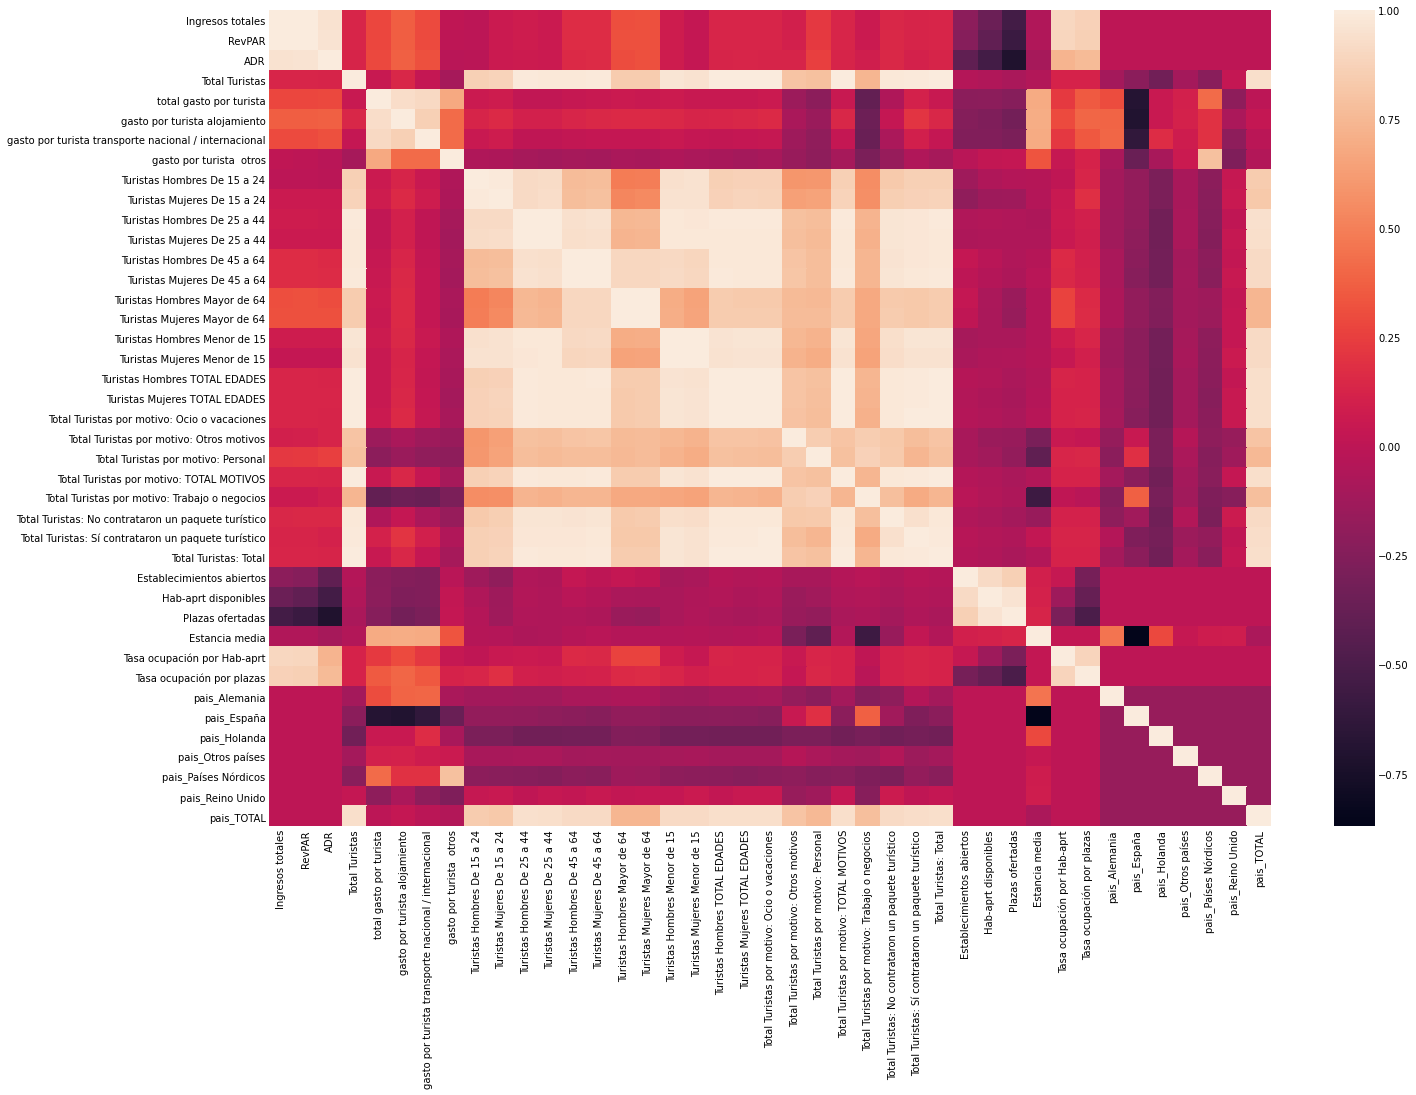

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = gasto_medio.corr(method='pearson', numeric_only = True)

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=False)
plt.show()

# 2. MODELO XGBoost

## (GRADIENT_BOOSTING)


La regresión lineal es uno de los muchos algoritmos que se pueden utilizar para resolver problemas de regresión. Es posible que otros algoritmos de regresión produzcan mejores resultados. La estrategia general consiste en experimentar con diferentes regresores para comparar puntuaciones.

**Hay una amplia gama de regresores, incluidos árboles de decisión, bosques aleatorios, aumento de gradiente XGBoost**

Aquí usaresmos el XGBoost que incluye un regresor, llamado XGBRegressor, que puede usarse en cualquier conjunto de datos de regresión. 

Usemos ahora XGBRegressor para comparar los resultados del conjunto de datos de gasto con los datos que obtuvimos en la regresión lineal.

Primero hay que instalarlo si no lo tenemos: **pip install xgboost**

In [33]:
from xgboost import XGBRegressor

In [34]:
RESULTADOS_XGBR = {}

xg_reg = XGBRegressor()
xg_reg.fit(X=X_train, y=Y_train)
xg_reg_train_preds = xg_reg.predict(X_train)
xg_reg_test_preds = xg_reg.predict(X_test)


RESULTADOS_XGBR["XGBR_train"] = evaluar_modelo(
    Y_train,
    xg_reg_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS_XGBR["XGBR_test"] = evaluar_modelo(
    Y_test,
    xg_reg_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS_XGBR)

,XGBR_train,XGBR_test
rmse,0.006647,34.036706
mae,0.004779,27.991318
adjusted_r2,1.000000,0.428319


## VISUALIZAMOS LA COMPARACION DE AMBOS MODELOS

In [35]:
RESULTADOS = pd.merge(pd.DataFrame(RESULTADOS_OLS),pd.DataFrame(RESULTADOS_XGBR), how="outer", left_index=True, right_index=True)
RESULTADOS.head()

,OLS_train,OLS_test,XGBR_train,XGBR_test
rmse,19.332206,47.779477,0.006647,34.036706
mae,13.560794,38.819622,0.004779,27.991318
adjusted_r2,0.904312,-0.126527,1.000000,0.428319


## HAREMOS UNA COMPARACIÓN SOBRE LOS DATOS PREDICHOS Y LOS DATOS REALES

In [36]:
diccionario = {'Valor Real': Y_test.to_numpy().flatten().tolist(),
                'Valor Predicho' : xg_reg_test_preds.flatten().tolist()}

In [37]:
comparaciones = pd.DataFrame(diccionario)
comparaciones.head(3)

,Valor Real,Valor Predicho
0,357.90,320.457336
1,278.47,260.517029
2,267.17,288.612854


Vemos las comparaciones y el % de error que sera positivo si predecimos por debajo del valor real, o negativo si lo hacemos por encima del valor real

In [38]:
comparaciones['% Error'] = 100 - (comparaciones['Valor Predicho']*100 / comparaciones['Valor Real'])
comparaciones

,Valor Real,Valor Predicho,% Error
0,357.90,320.457336,10.461767
1,278.47,260.517029,6.447004
2,267.17,288.612854,-8.025921
3,356.88,317.175781,11.125370
4,375.04,442.440369,-17.971515
5,299.24,273.355255,8.650162
6,333.11,315.337036,5.335464
7,282.21,323.516968,-14.636961
8,266.38,235.050507,11.761203
9,309.43,278.734894,9.919887


In [39]:
comparaciones['% Error'].describe()

count    56.000000
mean      1.988020
std       9.738133
min     -23.196314
25%      -4.790359
50%       5.140625
75%       8.780775
max      23.026309
Name: % Error, dtype: float64